# Predicting COVID-19 Cases with RNN LSTM Model

# 1. Data Preprocessing

## 1.1 Import Dependencies

In [53]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from collections import defaultdict
from sklearn.preprocessing import StandardScaler

In [28]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test_round2.csv
./data/train_round2.csv
./data/graph_round2.csv
./data/test.csv
./data/graph.csv
./data/submission_round2.csv
./data/submission.csv
./data/train.csv


## 1.2 Set Up Dataframes

### 1.2.1 Load Temporal Data

In [29]:
data_dir = 'data'
temporal_data_path = os.path.join(data_dir, 'train_round2.csv')
mobility_data_path = os.path.join(data_dir, 'graph_round2.csv')

temporal_data = pd.read_csv(temporal_data_path)
temporal_data.describe()

,ID,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
count,11250.000000,1.125000e+04,11250.000000,9419.000000,1.125000e+04,11250.000000,1.055000e+04,5047.000000,10550.000000,11250.000000,5047.000000
mean,5624.500000,9.583625e+04,3057.178311,40276.189086,5.907248e+04,1357.938709,1.161268e+06,6250.044185,3.300561,20085.845676,12.197144
std,3247.739599,1.516621e+05,5377.615328,81746.843553,1.243728e+05,1199.193935,2.031813e+06,13880.694435,2.039538,19319.956138,5.255183
min,0.000000,2.700000e+02,0.000000,0.000000,-9.890000e+02,32.771004,5.459000e+03,10.000000,0.000000,460.300152,2.302896
25%,2812.250000,1.054600e+04,273.000000,3030.500000,4.599500e+03,374.587118,1.579640e+05,595.000000,1.708176,5761.788808,8.387037
50%,5624.500000,4.175800e+04,1031.000000,10376.000000,1.579100e+04,1045.850447,4.901655e+05,2068.000000,2.802207,15172.226199,11.351161
75%,8436.750000,1.174958e+05,3387.000000,48028.000000,5.289675e+04,2046.182244,1.247765e+06,6134.500000,4.425834,27209.961598,15.396088
max,11249.000000,1.153529e+06,34319.000000,913796.000000,1.095798e+06,9537.675412,1.956515e+07,89995.000000,9.741481,134755.702292,38.501190


### 1.2.2 Load Mobility Data

In [30]:
mobility_data = pd.read_csv(mobility_data_path)
mobility_data.describe()

,04-12-2020,04-13-2020,04-14-2020,04-15-2020,04-16-2020,04-17-2020,04-18-2020,04-19-2020,04-20-2020,04-21-2020,...,11-13-2020,11-14-2020,11-15-2020,11-16-2020,11-17-2020,11-18-2020,11-19-2020,11-20-2020,11-21-2020,11-22-2020
count,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,...,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03
mean,1.031167e+04,1.170723e+04,1.151140e+04,1.178438e+04,1.179731e+04,1.230519e+04,1.163154e+04,1.057303e+04,1.205244e+04,1.279990e+04,...,1.647185e+04,1.548423e+04,1.363303e+04,1.425888e+04,1.423726e+04,1.449577e+04,1.500127e+04,1.559040e+04,1.508463e+04,1.366434e+04
std,1.034501e+05,1.168826e+05,1.139024e+05,1.167934e+05,1.169899e+05,1.218210e+05,1.149333e+05,1.045124e+05,1.190462e+05,1.268384e+05,...,1.615988e+05,1.517883e+05,1.341932e+05,1.402128e+05,1.403964e+05,1.429938e+05,1.476646e+05,1.528825e+05,1.469533e+05,1.330026e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.100000e+01,2.400000e+01,2.475000e+01,2.400000e+01,2.400000e+01,2.500000e+01,2.400000e+01,2.300000e+01,2.700000e+01,2.900000e+01,...,3.600000e+01,3.400000e+01,3.000000e+01,3.000000e+01,2.900000e+01,3.000000e+01,3.300000e+01,3.400000e+01,3.700000e+01,3.600000e+01
50%,7.150000e+01,8.100000e+01,7.950000e+01,8.300000e+01,8.300000e+01,8.500000e+01,7.900000e+01,7.600000e+01,8.700000e+01,9.900000e+01,...,1.280000e+02,1.230000e+02,1.110000e+02,1.050000e+02,1.000000e+02,1.080000e+02,1.170000e+02,1.255000e+02,1.370000e+02,1.340000e+02
75%,2.510000e+02,2.880000e+02,3.025000e+02,3.050000e+02,3.070000e+02,3.112500e+02,2.970000e+02,2.682500e+02,3.102500e+02,3.510000e+02,...,5.105000e+02,5.047500e+02,4.412500e+02,4.067500e+02,3.932500e+02,4.122500e+02,4.552500e+02,4.967500e+02,5.825000e+02,5.510000e+02
max,2.865996e+06,3.208712e+06,3.080286e+06,3.198044e+06,3.216221e+06,3.350439e+06,3.152302e+06,2.825683e+06,3.248109e+06,3.475880e+06,...,4.462261e+06,4.190015e+06,3.665221e+06,3.782182e+06,3.809145e+06,3.899828e+06,4.037380e+06,4.234231e+06,4.059547e+06,3.610555e+06


### 1.2.3 Classify Temporal Data by State

In [31]:
states = list(np.unique(temporal_data['Province_State']))
state_temporal_data = dict.fromkeys(states, None)
state_temporal_scaler = {}
dropped_attr = ['Date',
                'Deaths',
                'Active',
                'ID', 
                'Province_State', 
                'Incident_Rate', 
                'Recovered', 
                'People_Tested', 
                'People_Hospitalized', 
                'Mortality_Rate', 
                'Testing_Rate', 
                'Hospitalization_Rate']

for s in states:
    df_filter = temporal_data['Province_State'] == s
    state_df = temporal_data[df_filter]
    state_temporal_data[s] = state_df.drop(dropped_attr, 1)
    save_columns = state_temporal_data[s].columns
    state_temporal_scaler[s] = StandardScaler()
    state_temporal_data[s] = state_temporal_scaler[s].fit_transform(state_temporal_data[s])
    state_temporal_data[s] = pd.DataFrame(state_temporal_data[s], columns=save_columns)
    
state_temporal_data['California']

,Confirmed
0,-1.364196
1,-1.360897
2,-1.356760
3,-1.352899
4,-1.350021
...,...
220,1.658917
221,1.697050
222,1.733562
223,1.779101


### 1.2.4 Classify Mobility Data by State

In [32]:
states = list(np.unique(mobility_data['source_state']))
state_mobility_data = dict.fromkeys(states, None)
state_mobility_scaler = {}
dropped_attr = ['source_state', 'target_state']

for s in states:
    df_filter = mobility_data['target_state'] == s
    state_mobility_df = mobility_data[df_filter].drop(dropped_attr, 1)
    state_mobility_data[s] = pd.DataFrame({'Mobility': {date: state_mobility_df.loc[:, date].sum(axis=0) for date in state_mobility_df.columns}})
    state_mobility_scaler[s] = StandardScaler()
    state_mobility_data[s] = state_mobility_scaler[s].fit_transform(state_mobility_data[s])
    state_mobility_data[s] = pd.DataFrame(state_mobility_data[s], columns=save_columns)
    
state_mobility_data['California']

,Confirmed
0,-3.574169
1,-2.490195
2,-2.447612
3,-2.302845
4,-2.338558
...,...
220,-0.512472
221,-0.389410
222,0.137881
223,-0.094324


## 1.3. Data Visualization

### 1.3.1 Plot Daily Cumulative Confirmed Cases Trend

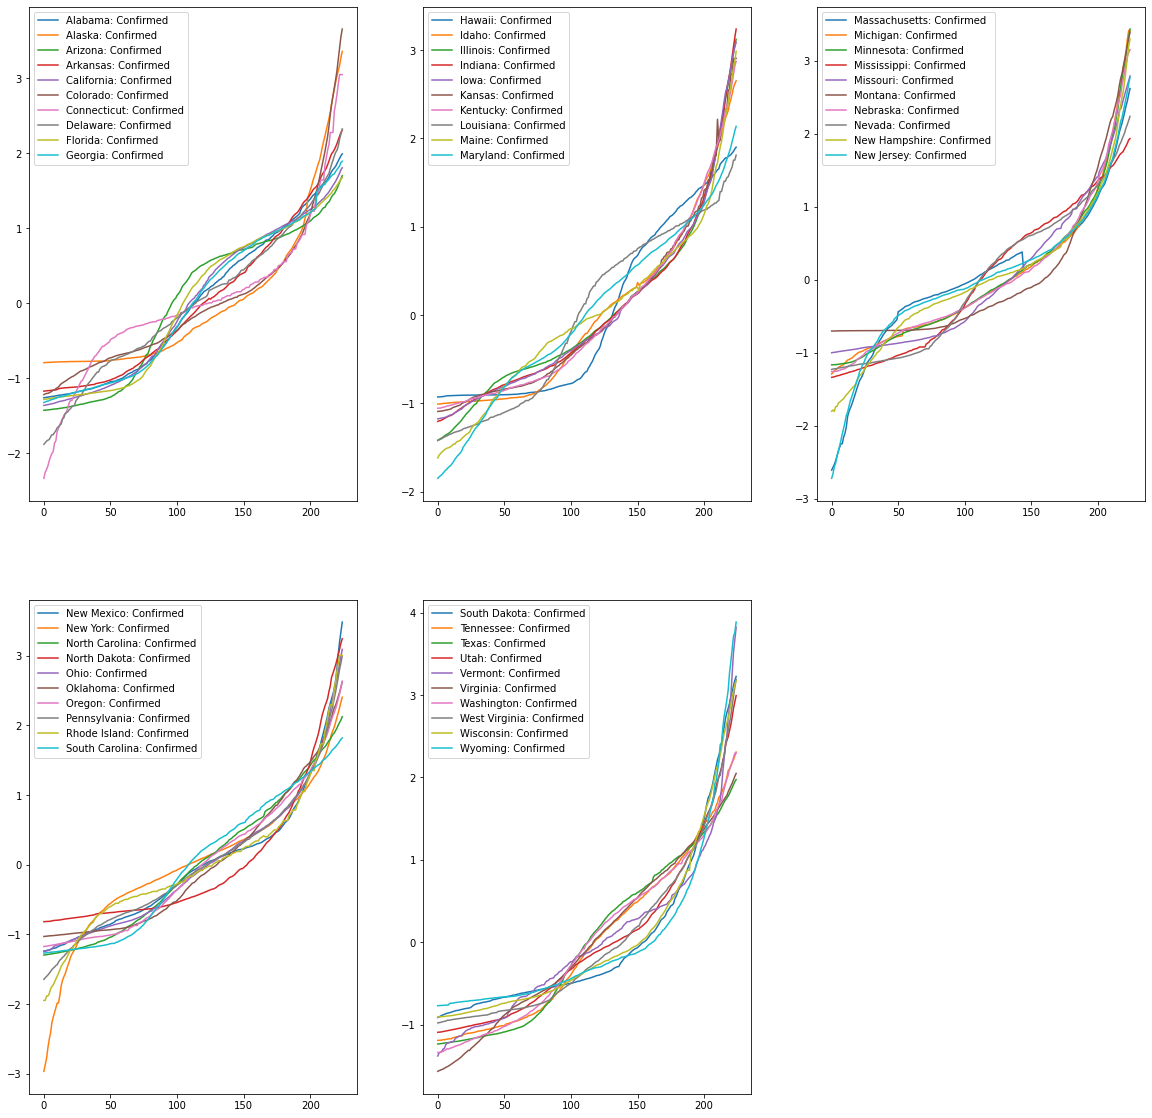

In [37]:
state_count = 1
figure_count = 1
plt.figure(figsize=(20, 20))
for state, confirmed in state_temporal_data.items():
    if state_count == 1:
        plt.subplot(2,3,figure_count)
        plt.yscale('linear')
    plt.plot(confirmed, label=f"{state}: Confirmed")
    plt.legend(loc='best')
    state_count += 1
    if state_count == 11:
        state_count %= 10
        figure_count += 1

### 1.3.2 Plot Daily Mobility Trend

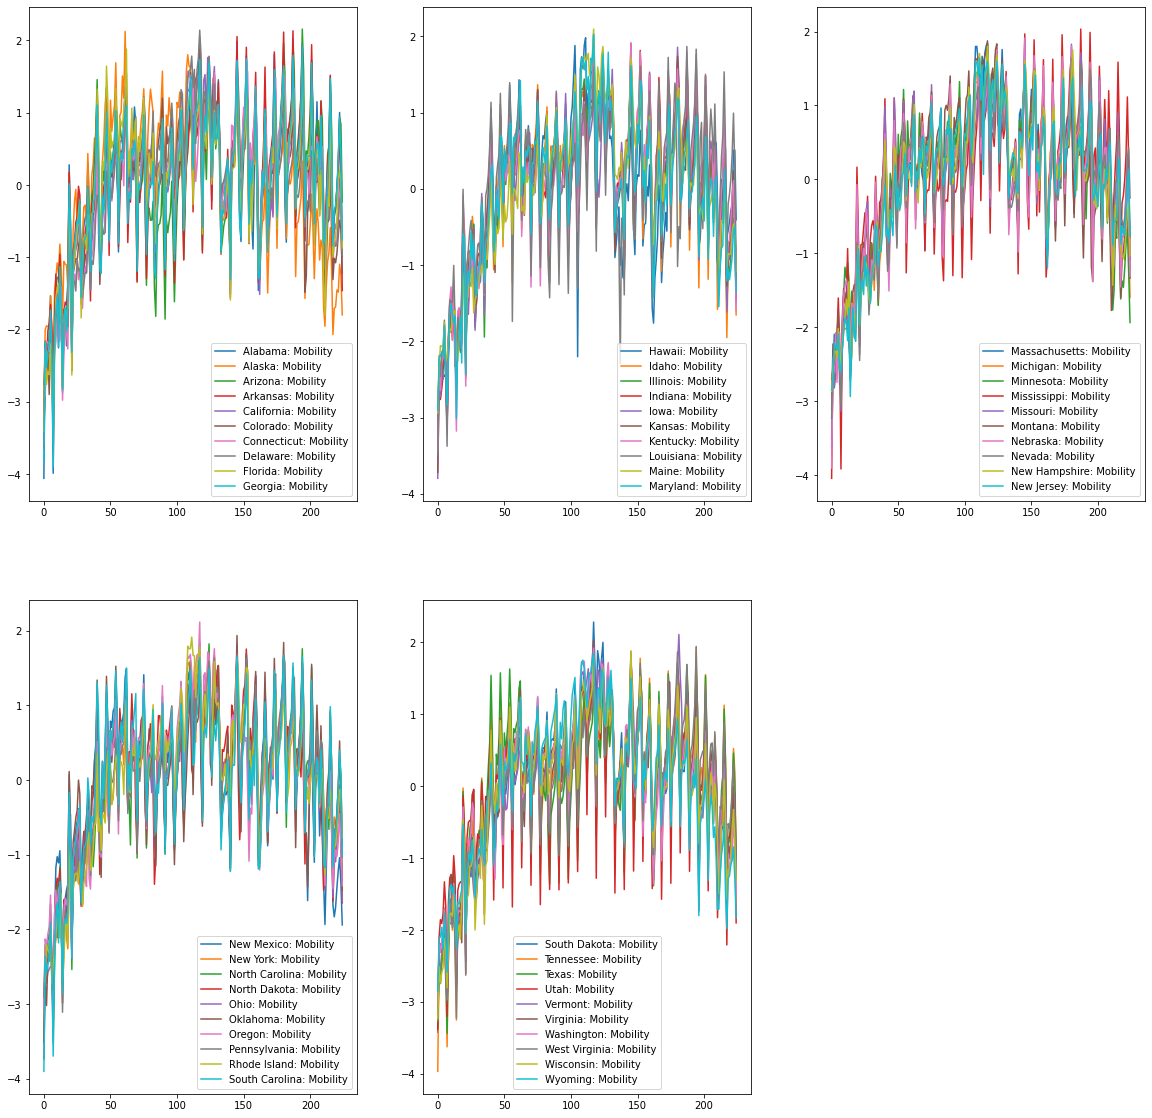

In [38]:
state_count = 1
figure_count = 1
plt.figure(figsize=(20, 20))
for state, mobility in state_mobility_data.items():
    if state_count == 1:
        plt.subplot(2,3,figure_count)
        plt.yscale('linear')
    plt.plot(mobility, label=f"{state}: Mobility")
    plt.legend(loc='best')
    state_count += 1
    if state_count == 11:
        state_count %= 10
        figure_count += 1

## 1.4 Create Cross-validation Datasets

In [102]:
def np_array():
    return np.array([])

state_temporal_train = defaultdict(list)
state_mobility_train = defaultdict(list)
state_confirmed_train = defaultdict(list)

state_temporal_valid = {}
state_mobility_valid = {}
state_confirmed_valid = {}

for i in range(state_temporal_data['California'].shape[0] - 7):
    for s in state_temporal_data.keys():
        state_temporal_train[s].append(np.array([np.array(state_temporal_data[s][i:i + 7])]))
        state_mobility_train[s].append(np.array([np.array(state_mobility_data[s][i:i + 7])]))
        state_confirmed_train[s].append(np.array([np.array(state_temporal_data[s].loc[i + 7])]))
        
print(state_temporal_train['California'][0].shape)
print(state_temporal_train['California'][0])

(1, 7, 1)
[[[-1.36419553]
  [-1.36089731]
  [-1.35676002]
  [-1.35289855]
  [-1.35002131]
  [-1.34572434]
  [-1.34185125]]]


# 2. Building the RNN Model with LSTM

## 2.1 Import Dependencies

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.models import Model

## 2.2 Initialize Model

In [153]:
seq_len = 7

temporal_input_layer = Input(shape=(seq_len, 1), name='temporal_input')
temporal_rnn_layer = LSTM(10, return_sequences=True, recurrent_dropout=0.2, name='temporal_rnn')(temporal_input_layer)
temporal_second_rnn_layer = LSTM(20, return_sequences=False, recurrent_dropout=0.2, name='temporal_second_rnn')(temporal_rnn_layer)
# temporal_dense_layer = Dense(5, name='temporal_dense')(temporal_second_rnn_layer)

mobility_input_layer = Input(shape=(seq_len, 1), name='mobility_input')
mobility_rnn_layer = LSTM(10, return_sequences=True, recurrent_dropout=0.2, name='mobility_rnn')(mobility_input_layer)
mobility_second_rnn_layer = LSTM(20, return_sequences=False, recurrent_dropout=0.2, name='mobility_second_rnn')(mobility_rnn_layer)
# mobility_dense_layer = Dense(5, name='mobility_dense')(mobility_second_rnn_layer)

merged_layer = Concatenate(axis=-1, name='concatenate')([temporal_second_rnn_layer, mobility_second_rnn_layer])
# merged_rnn_layer = LSTM(10, return_sequences=False, recurrent_dropout=0.2, name='merged_rnn')(merged_layer)
# merged_second_rnn_layer = LSTM(10, return_sequences=False, recurrent_dropout=0.2, name='merged_second_rnn')(merged_rnn_layer)
merged_dense_layer = Dense(units=10, name='merged_dense')(merged_layer)
# merged_dropout_layer = Dropout(0.3, name='merged_dropout')(merged_dense_layer)
confirmed = Dense(1, activation=layers.LeakyReLU(alpha=0.1), name='confirmed')(merged_dense_layer)

model = Model([temporal_input_layer, mobility_input_layer], [confirmed], name='COVID_pred')

model.summary()

Model: "COVID_pred"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
temporal_input (InputLayer)     [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
mobility_input (InputLayer)     [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
temporal_rnn (LSTM)             (None, 7, 10)        480         temporal_input[0][0]             
__________________________________________________________________________________________________
mobility_rnn (LSTM)             (None, 7, 10)        480         mobility_input[0][0]             
_________________________________________________________________________________________

In [154]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([state_temporal_train['California'], state_mobility_train['California']], state_confirmed_train['California'], epochs=100, batch_size=16, verbose=1)

Epoch 1/100
1/1 [==============================] - 0s 948us/step - loss: 2.4708
Epoch 2/100
1/1 [==============================] - 0s 852us/step - loss: 2.3671
Epoch 3/100
1/1 [==============================] - 0s 968us/step - loss: 2.0939
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 2.0711
Epoch 5/100
1/1 [==============================] - 0s 930us/step - loss: 1.8925
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 1.7855
Epoch 7/100
1/1 [==============================] - 0s 876us/step - loss: 1.7768
Epoch 8/100
1/1 [==============================] - 0s 861us/step - loss: 1.7683
Epoch 9/100
1/1 [==============================] - 0s 877us/step - loss: 1.7541
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 1.7562
Epoch 11/100
1/1 [==============================] - 0s 766us/step - loss: 1.7432
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 1.7348
Epoch 13/100
1/1 [===========================